<a href="https://colab.research.google.com/github/Amadou794545/Segmentation-des-donnees-bancaires/blob/main/Segmentation_des_donn%C3%A9es_bancaires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comprehension du sujet

L'objectif est d'utiliser le clustering (ex : K-Means) pour regrouper les clients d‚Äôune banque en diff√©rents segments en fonction de leur comportement financier. Cela permet √† la banque de mieux comprendre ses clients et d‚Äôadapter ses offres (cartes bancaires, cr√©dits, taux d‚Äôint√©r√™t, etc.).

#Importation

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler,RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans

#Importation dataset

In [66]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/janiobachmann/bank-marketing-dataset/versions/1


In [67]:
import os
print(os.listdir('/root/.cache/kagglehub/datasets/janiobachmann/bank-marketing-dataset/versions/1'))


['bank.csv']


In [68]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/janiobachmann/bank-marketing-dataset/versions/1/bank.csv')

In [69]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

Informations d√©mographiques¬†: √¢ge, emploi, √©tat civil, √©ducation

Informations financi√®res¬†: d√©faut, solde, logement, pr√™t

D√©tails de la campagne marketing¬†: contact, jour, mois, dur√©e, campagne, pdays (nombre de jours depuis le dernier contact avec le client lors d'une campagne pr√©c√©dente), previous (nombre de contacts avant cette campagne), poutcome (r√©sultat de la campagne marketing pr√©c√©dente)

Variable cible¬†: d√©p√¥t

In [70]:
df.dataframeName = 'bank.csv'


#Nettoyage et comprehension du dataset


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [72]:
df.shape

(11162, 17)

In [73]:
df['contact'].value_counts()

contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64

In [74]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [75]:
df['marital'].value_counts()

marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64

In [76]:
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [77]:
df['poutcome'].value_counts()

poutcome
unknown    8326
failure    1228
success    1071
other       537
Name: count, dtype: int64

#EDA

In [78]:
df.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

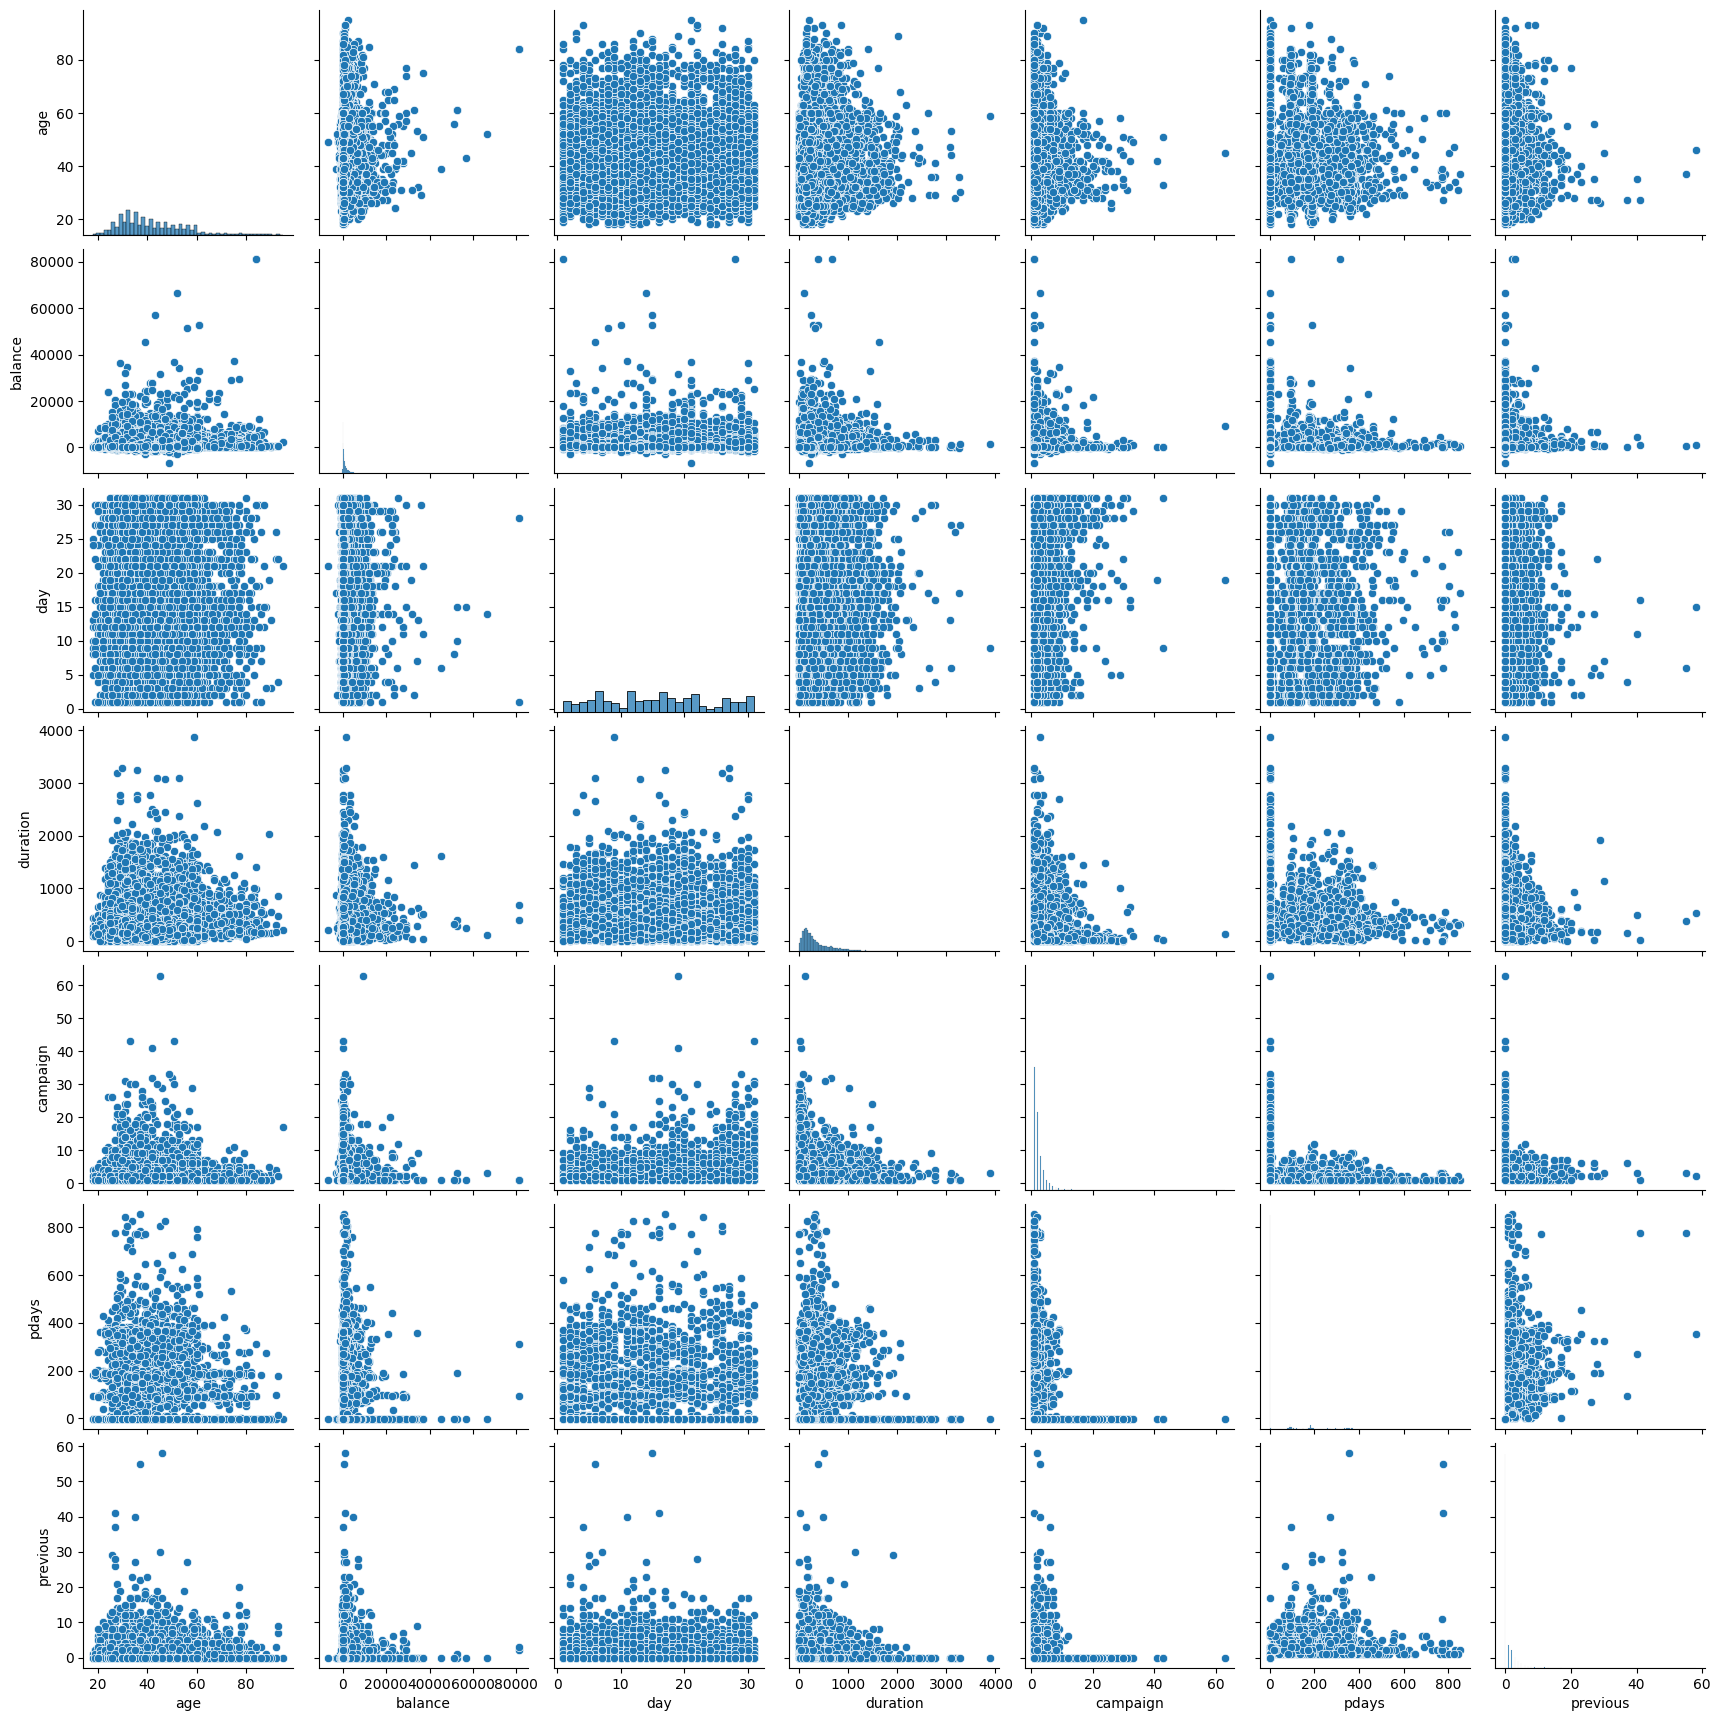

In [79]:
sns.pairplot(df)

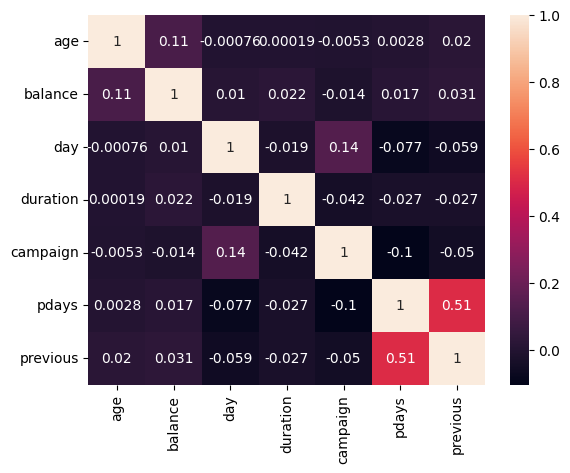

In [80]:
numerical_features = df.select_dtypes(include=np.number).columns
numerical_df = df[numerical_features]

correlation_matrix = numerical_df.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

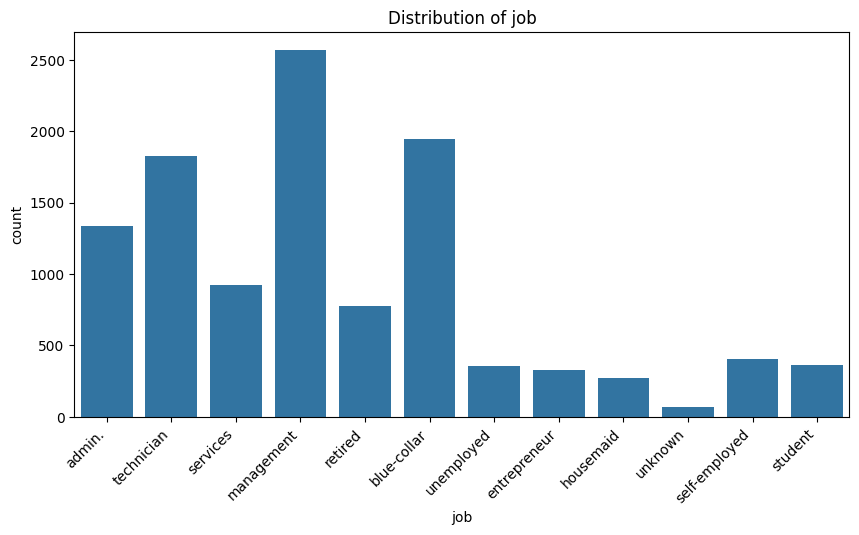

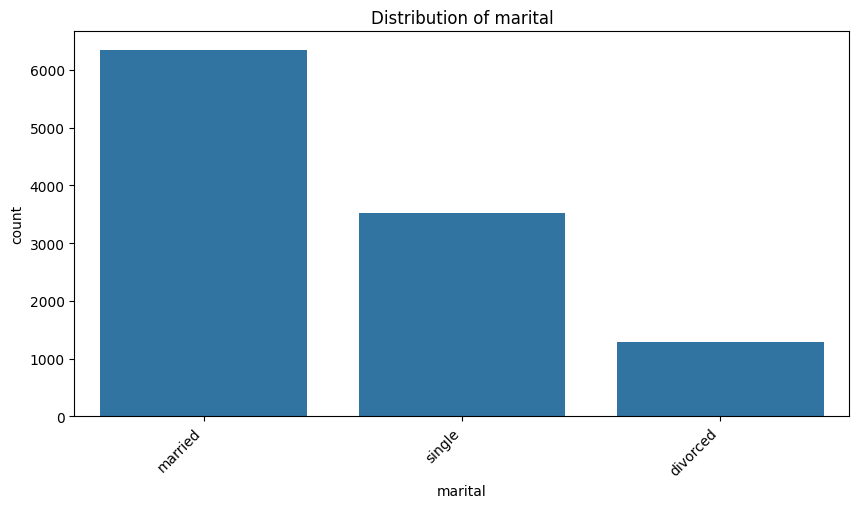

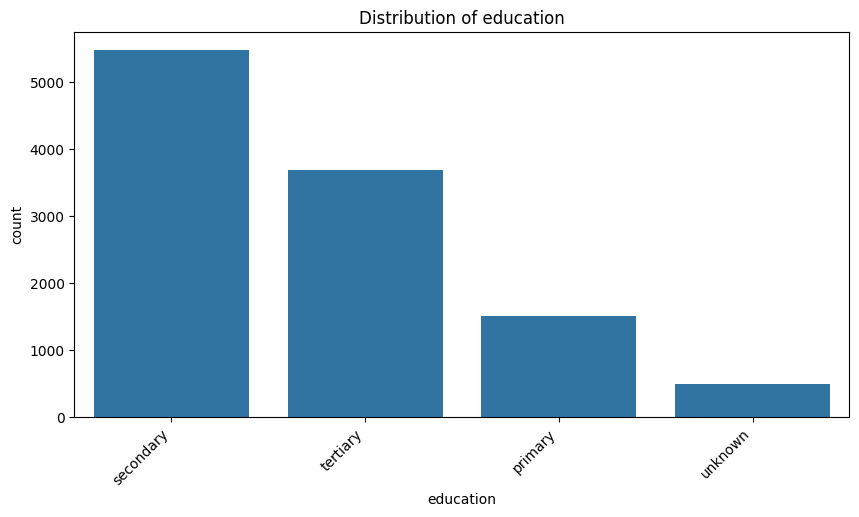

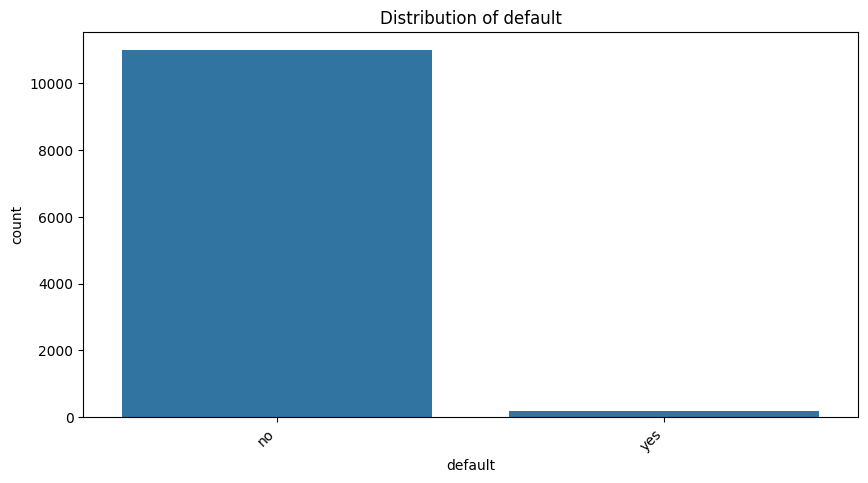

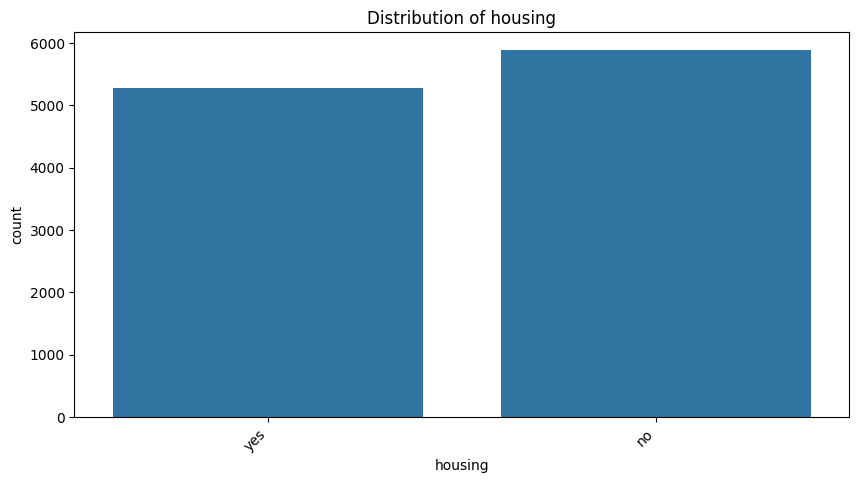

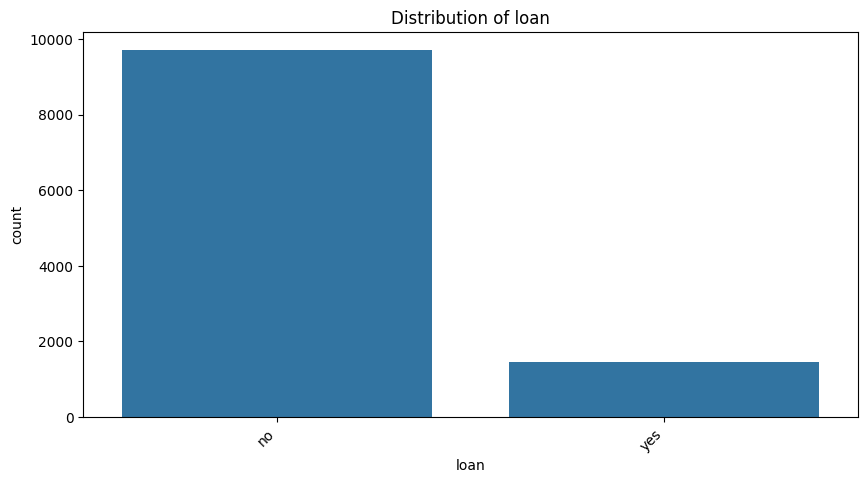

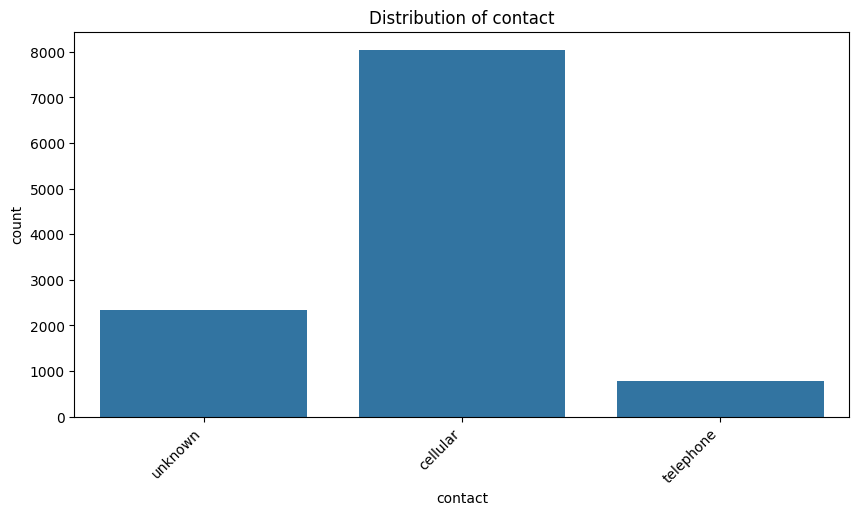

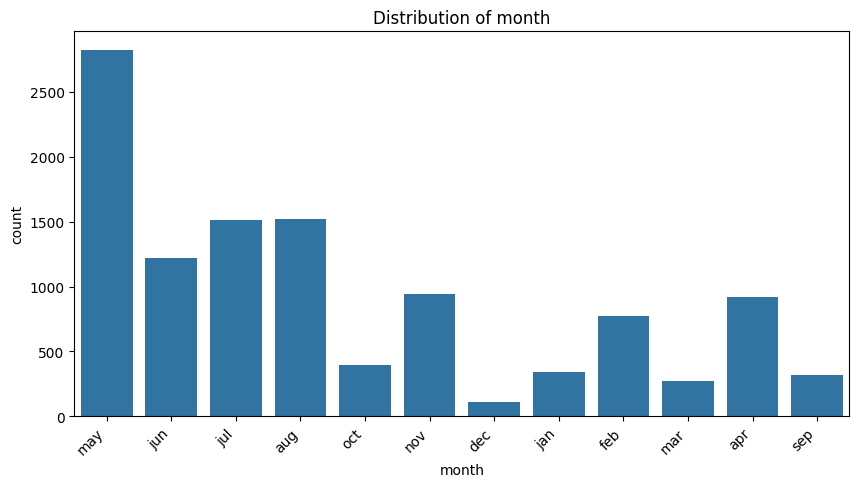

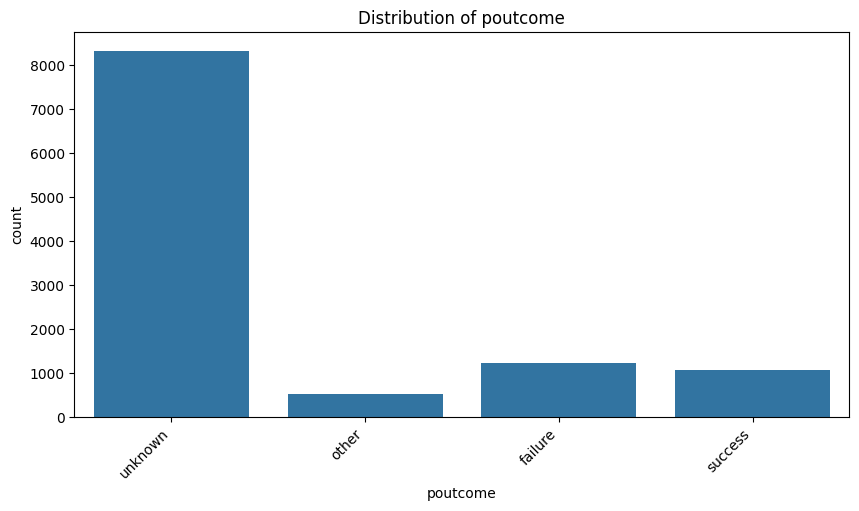

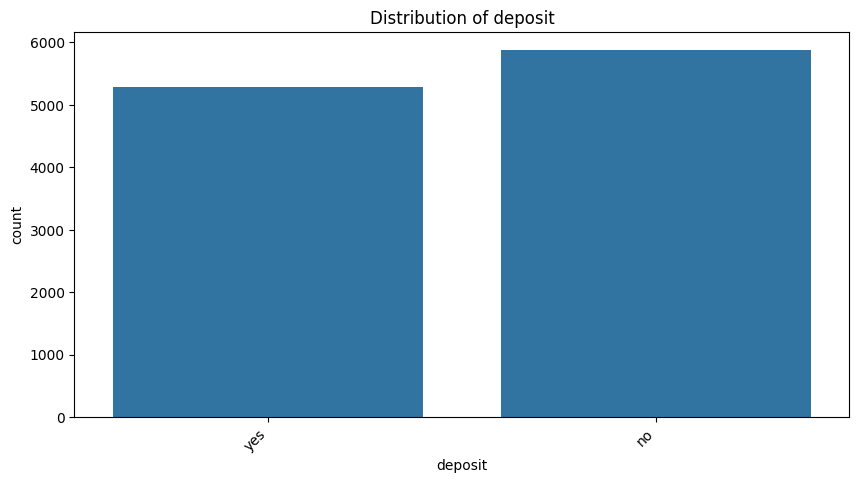

In [81]:
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

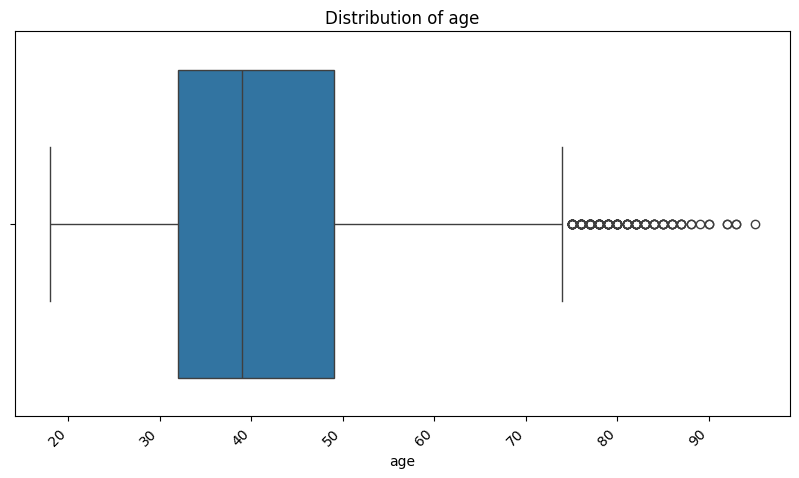

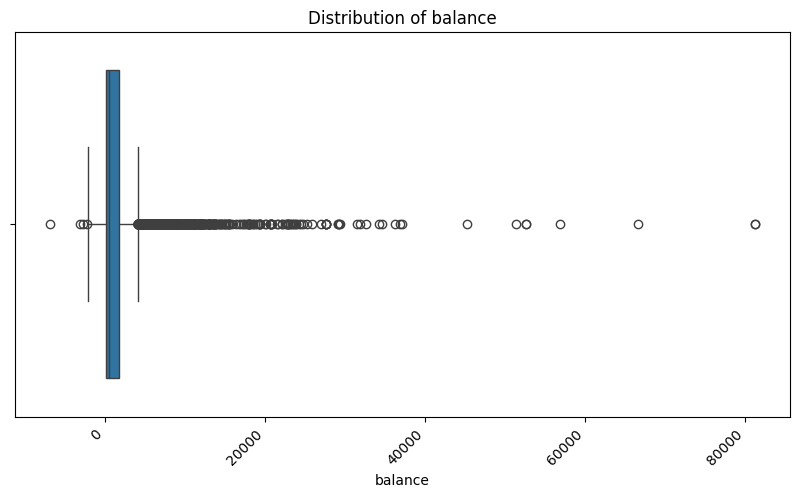

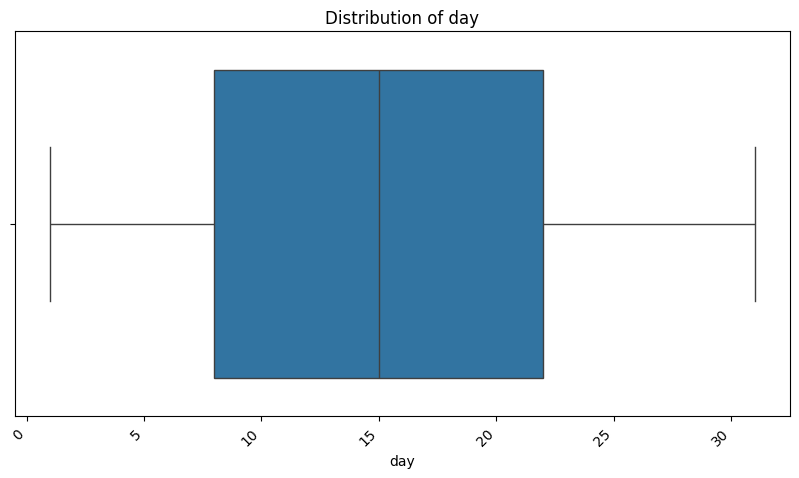

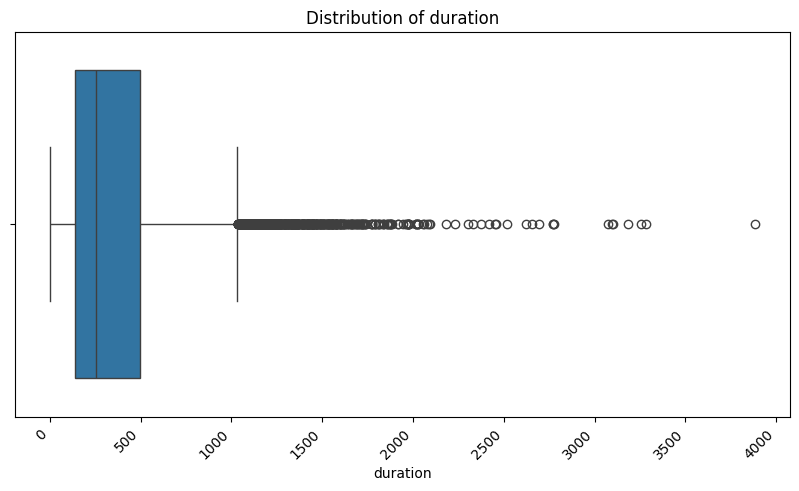

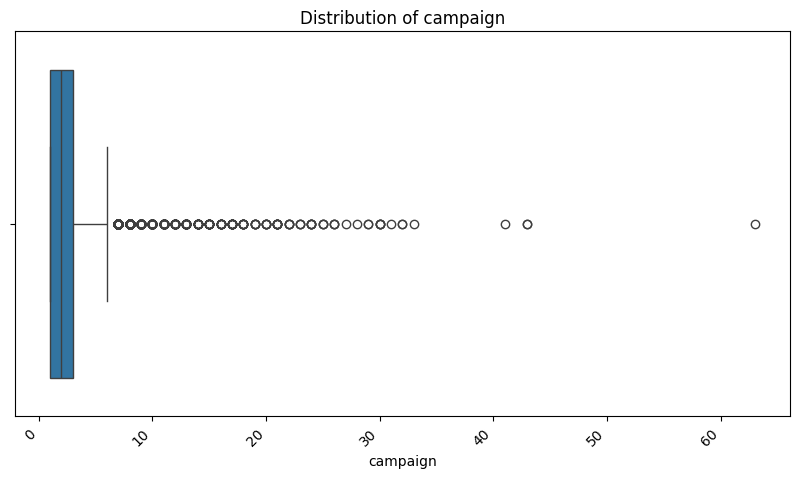

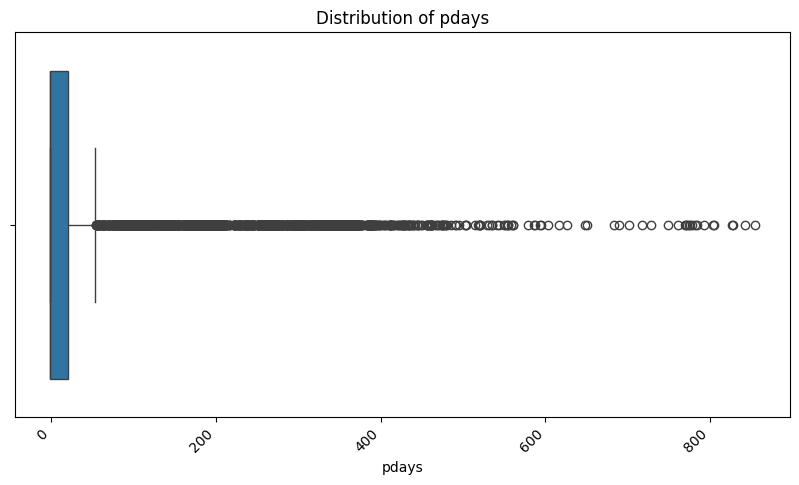

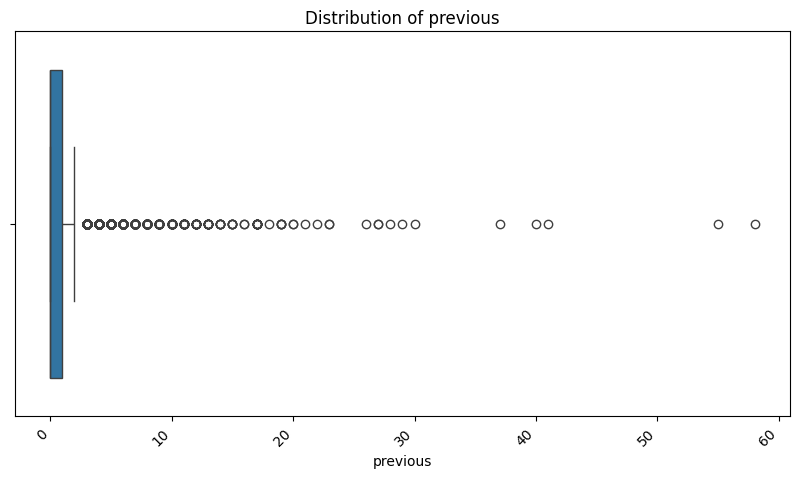

In [82]:
for col in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

**Text de Shapiro-Wilk** pour verifier la normalit√© des variables

 Interpr√©tation :

* p > 0.05 ‚Üí On ne rejette pas l‚Äôhypoth√®se de normalit√© (distribution normale).
* p < 0.05 ‚Üí Les donn√©es ne sont pas normales.


üìä **Analyse de la normalit√© pour la variable : age**
Statistique de test : 0.9472203150961662, p-valeur : 1.4619542487099597e-52
‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11162.
  res = hypotest_fun_out(*samples, **kwds)


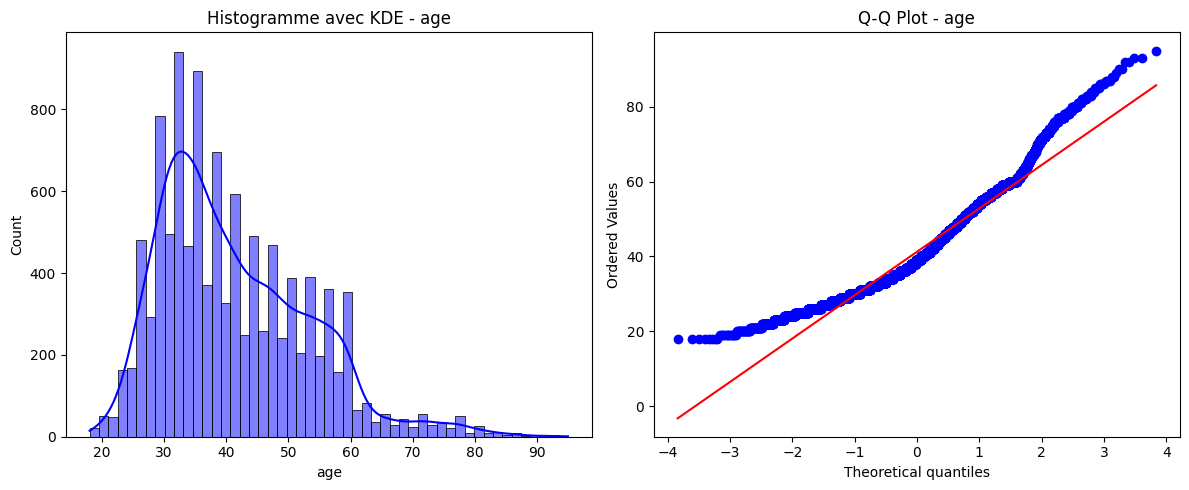


üìä **Analyse de la normalit√© pour la variable : balance**
Statistique de test : 0.4635691303241063, p-valeur : 2.9431713640543387e-102
‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11162.
  res = hypotest_fun_out(*samples, **kwds)


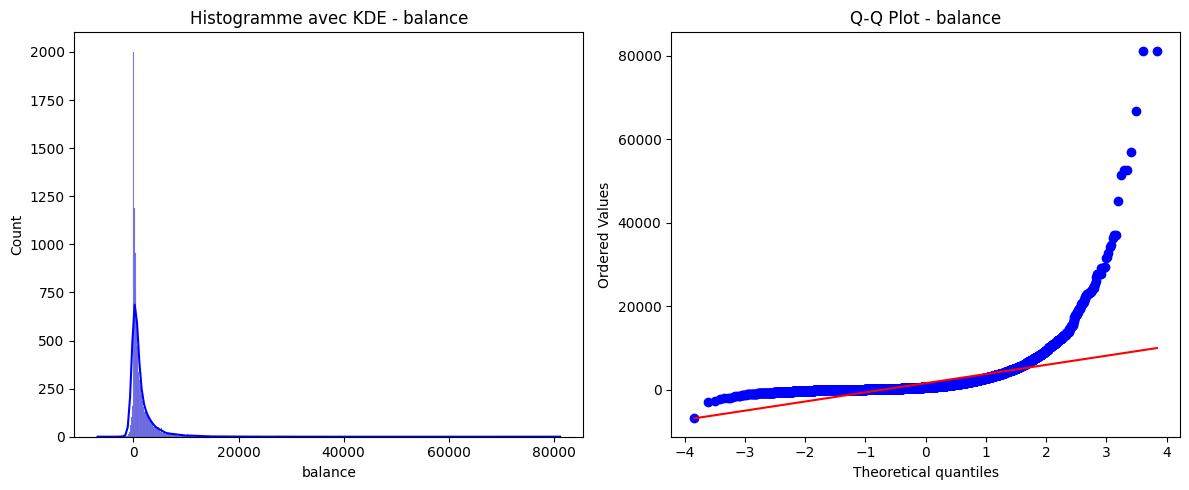


üìä **Analyse de la normalit√© pour la variable : day**
Statistique de test : 0.9592061148351212, p-valeur : 4.470374855656178e-48
‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11162.
  res = hypotest_fun_out(*samples, **kwds)


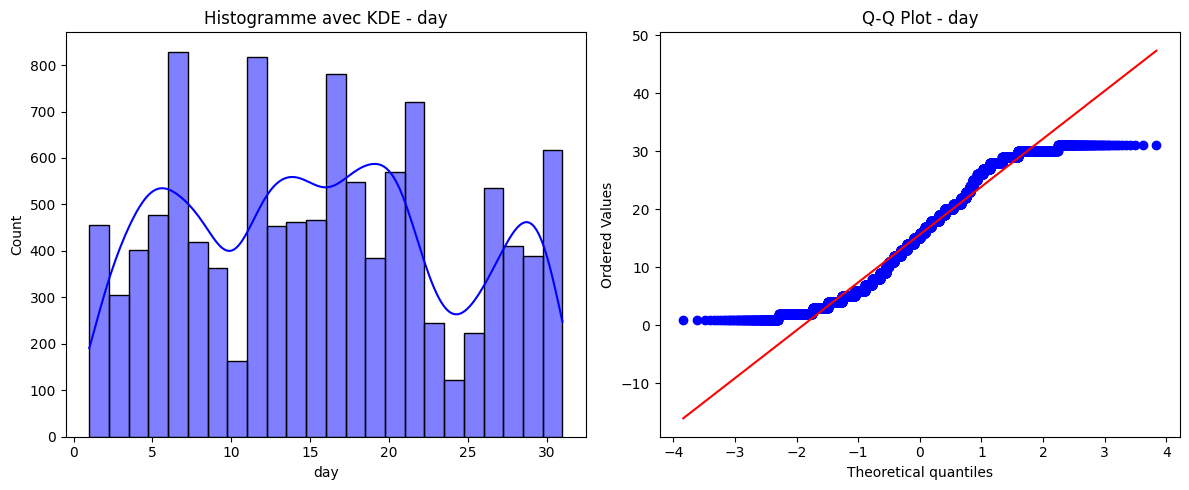


üìä **Analyse de la normalit√© pour la variable : duration**
Statistique de test : 0.8009227287872124, p-valeur : 5.844677392330821e-79
‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11162.
  res = hypotest_fun_out(*samples, **kwds)


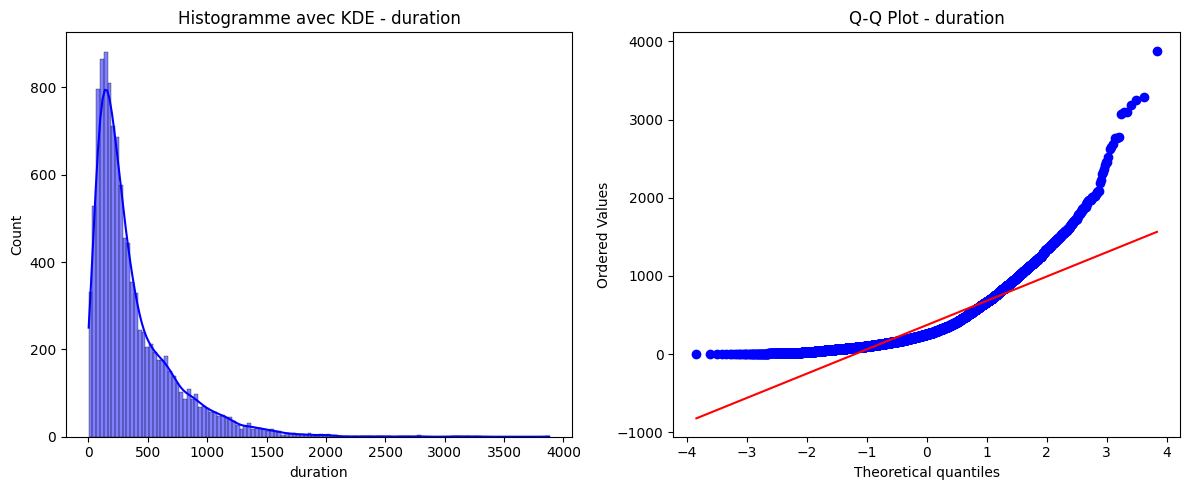


üìä **Analyse de la normalit√© pour la variable : campaign**
Statistique de test : 0.5385304870909646, p-valeur : 1.6004962410695137e-98
‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11162.
  res = hypotest_fun_out(*samples, **kwds)


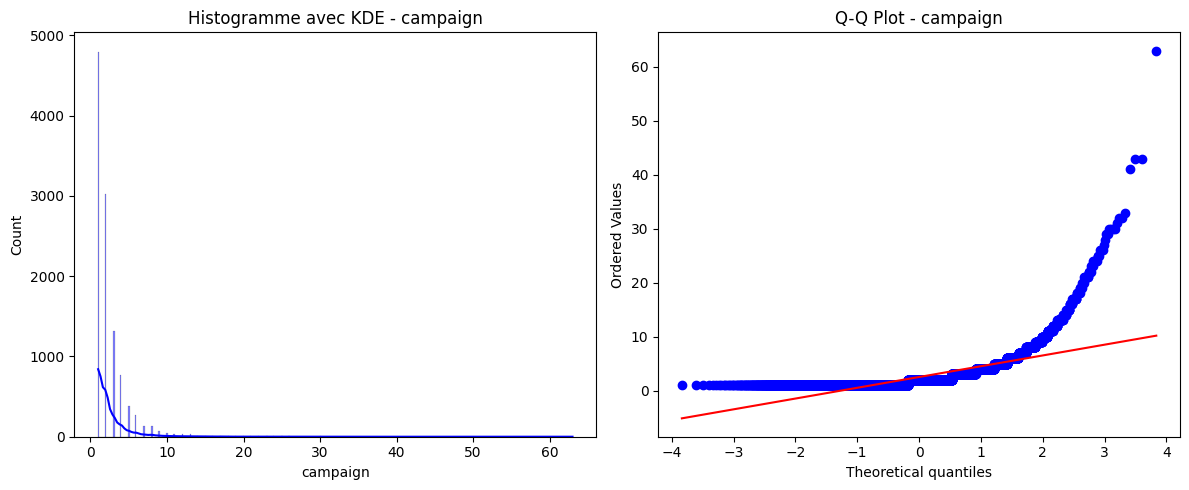


üìä **Analyse de la normalit√© pour la variable : pdays**
Statistique de test : 0.5560542237830806, p-valeur : 1.424137644947736e-97
‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11162.
  res = hypotest_fun_out(*samples, **kwds)


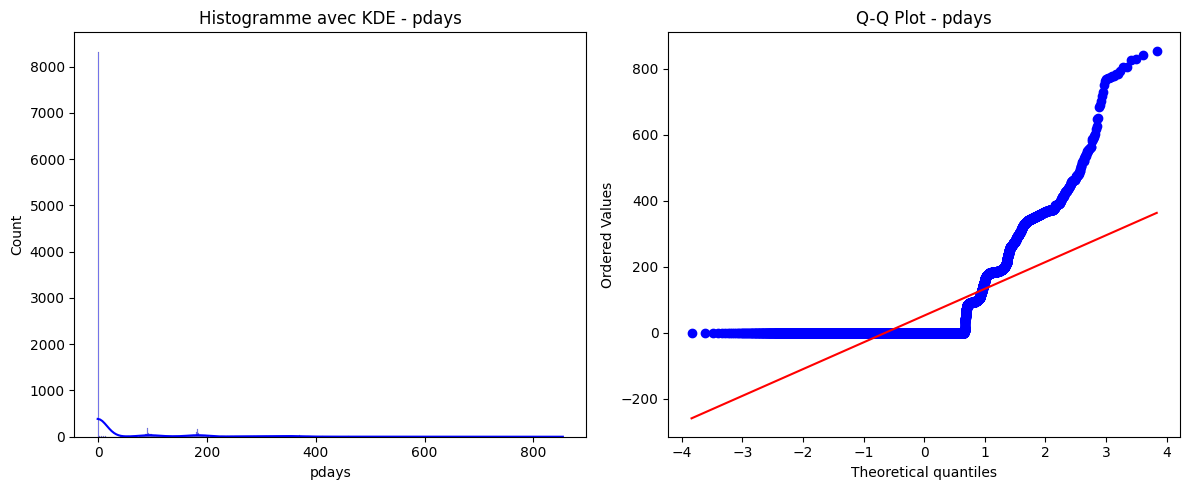


üìä **Analyse de la normalit√© pour la variable : previous**
Statistique de test : 0.39810802478611873, p-valeur : 3.661388905170451e-105
‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11162.
  res = hypotest_fun_out(*samples, **kwds)


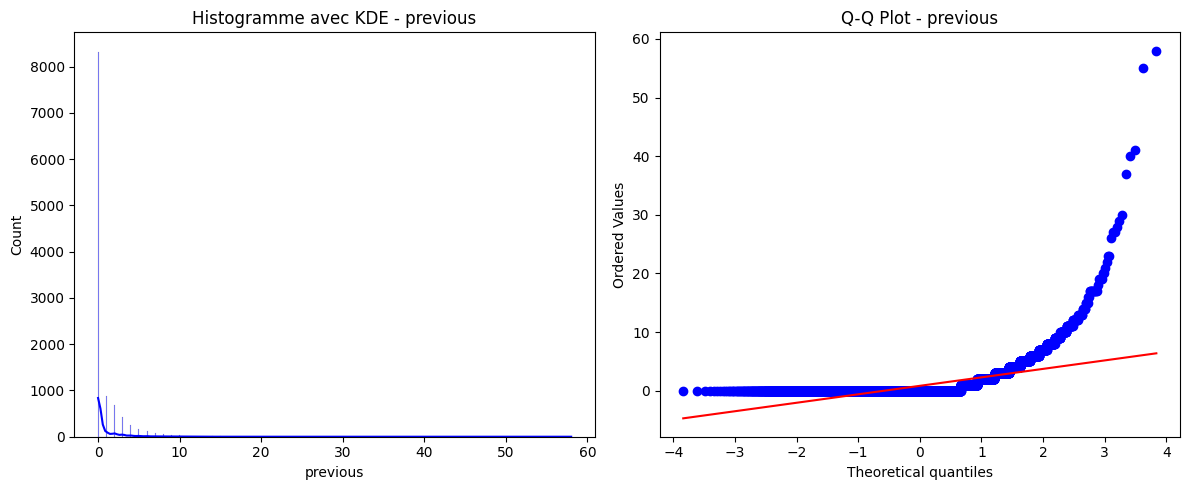

In [83]:
import scipy.stats as stats

numerical_features = df.select_dtypes(include=np.number).columns

for col in numerical_features:
    print(f"\nüìä **Analyse de la normalit√© pour la variable : {col}**")

    stat, p = shapiro(df[col])
    print(f"Statistique de test : {stat}, p-valeur : {p}")

    if p > 0.05:
        print("‚úÖ Les donn√©es suivent une distribution normale (on ne rejette pas H0)")
    else:
        print("‚ùå Les donn√©es ne suivent pas une distribution normale (on rejette H0)")

    # üìä Affichage des graphiques
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogramme avec courbe de densit√©
    sns.histplot(df[col], kde=True, ax=axes[0], color='blue')
    axes[0].set_title(f"Histogramme avec KDE - {col}")

    # Q-Q Plot
    stats.probplot(df[col], dist="norm", plot=axes[1])
    axes[1].set_title(f"Q-Q Plot - {col}")

    plt.tight_layout()
    plt.show()


les donn√©es qui ne suivent pas une distribution normale on doit alors faire une standardisation ou une normalisation

In [84]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       11162 non-null  int64
 1   balance   11162 non-null  int64
 2   day       11162 non-null  int64
 3   duration  11162 non-null  int64
 4   campaign  11162 non-null  int64
 5   pdays     11162 non-null  int64
 6   previous  11162 non-null  int64
dtypes: int64(7)
memory usage: 610.6 KB


#Preprocessing

Encodage du dataset

In [85]:
df

age          job  marital  education default  balance housing loan  \
0       59       admin.  married  secondary      no     2343     yes   no   
1       56       admin.  married  secondary      no       45      no   no   
2       41   technician  married  secondary      no     1270     yes   no   
3       55     services  married  secondary      no     2476     yes   no   
4       54       admin.  married   tertiary      no      184      no   no   
...    ...          ...      ...        ...     ...      ...     ...  ...   
11157   33  blue-collar   single    primary      no        1     yes   no   
11158   39     services  married  secondary      no      733      no   no   
11159   32   technician   single  secondary      no       29      no   no   
11160   43   technician  married  secondary      no        0      no  yes   
11161   34   technician  married  secondary      no        0      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
3       unknown    5   may       579         1     -1         0  unknown   
4       unknown    5   may       673         2     -1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11157  cellular   20   apr       257         1     -1         0  unknown   
11158   unknown   16   jun        83         4     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

      deposit  
0         yes  
1         yes  
2         yes  
3         yes  
4         yes  
...       ...  
11157      no  
11158      no  
11159      no  
11160      no  
11161      no  

[11162 rows x 17 columns]

In [90]:
categorical_columns = ['poutcome', 'month', 'contact', 'housing']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(df[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))

Standardisation

In [91]:
numerical_columns = ['duration', 'balance', 'pdays', 'age']
scaler = RobustScaler()
scaled_numerical = scaler.fit_transform(df[numerical_columns])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

In [92]:
processed_data = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)


In [93]:
processed_data.head()

duration   balance  pdays       age  poutcome_other  poutcome_success  \
0  2.198324  1.130517    0.0  1.176471             0.0               0.0   
1  3.385475 -0.318411    0.0  1.000000             0.0               0.0   
2  3.167598  0.453972    0.0  0.117647             0.0               0.0   
3  0.905028  1.214376    0.0  0.941176             0.0               0.0   
4  1.167598 -0.230769    0.0  0.882353             0.0               0.0   

   poutcome_unknown  month_aug  month_dec  month_feb  ...  month_jul  \
0               1.0        0.0        0.0        0.0  ...        0.0   
1               1.0        0.0        0.0        0.0  ...        0.0   
2               1.0        0.0        0.0        0.0  ...        0.0   
3               1.0        0.0        0.0        0.0  ...        0.0   
4               1.0        0.0        0.0        0.0  ...        0.0   

   month_jun  month_mar  month_may  month_nov  month_oct  month_sep  \
0        0.0        0.0        1.0        0.0        0.0        0.0   
1        0.0        0.0        1.0        0.0        0.0        0.0   
2        0.0        0.0        1.0        0.0        0.0        0.0   
3        0.0        0.0        1.0        0.0        0.0        0.0   
4        0.0        0.0        1.0        0.0        0.0        0.0   

   contact_telephone  contact_unknown  housing_yes  
0                0.0              1.0          1.0  
1                0.0              1.0          0.0  
2                0.0              1.0          1.0  
3                0.0              1.0          1.0  
4                0.0              1.0          0.0  

[5 rows x 21 columns]

#Clustering

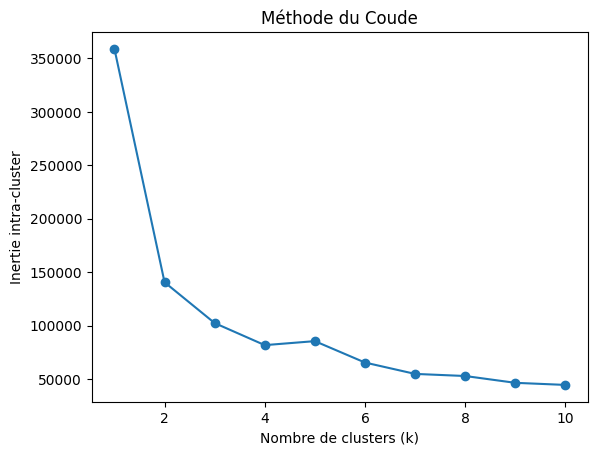

In [95]:
# Supposons que "X" soit notre dataset avec les features
inerties = []
K_range = range(1, 11)  # Tester k de 1 √† 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    inerties.append(kmeans.inertia_)  # Inertie intra-cluster

# Tracer la courbe
plt.plot(K_range, inerties, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.title("M√©thode du Coude")
plt.show()

In [96]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(processed_data)

In [97]:
for i in range(k):
    print(f"Cluster {i}:")
    print(df[df['Cluster'] == i].describe())
    print("\n")

Cluster 0:
               age       balance          day     duration     campaign  \
count  8451.000000   8451.000000  8451.000000  8451.000000  8451.000000   
mean     41.054668   1441.123181    16.028281   380.078334     2.702994   
std      11.565787   3039.216706     8.465805   365.354866     3.011743   
min      18.000000  -6847.000000     1.000000     2.000000     1.000000   
25%      32.000000     96.000000     8.000000   131.000000     1.000000   
50%      39.000000    500.000000    16.000000   250.000000     2.000000   
75%      49.000000   1588.000000    22.000000   524.000000     3.000000   
max      95.000000  66653.000000    31.000000  3881.000000    63.000000   

             pdays     previous  Cluster  
count  8451.000000  8451.000000   8451.0  
mean     -0.471424     0.054195      0.0  
std       5.146652     0.564552      0.0  
min      -1.000000     0.000000      0.0  
25%      -1.000000     0.000000      0.0  
50%      -1.000000     0.000000      0.0  
75%      -1.

In [99]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(processed_data, df['Cluster'])
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.5690601372629022


Cluster 0 : Clients peu engag√©s, contact√©s pour la premi√®re fois
* Ils ont rarement √©t√© contact√©s avant (pdays ‚âà -1 et previous ‚âà 0).
* Leur solde est tr√®s dispers√©, allant du d√©couvert (-6847) √† 66653.
* Dur√©e des appels la plus longue (380 sec) ‚Üí Peut-√™tre parce qu'ils d√©couvrent l‚Äôoffre ?
* Hypoth√®se : Ce sont peut-√™tre des clients nouveaux ou peu actifs, qu‚Äôon essaie d‚Äôattirer.

Cluster 1 : Clients r√©activ√©s apr√®s un long moment
* Ils ont d√©j√† √©t√© contact√©s avant (previous ‚âà 3.12, pdays ‚âà 354 jours).
* Leur solde bancaire est similaire √† celui du Cluster 0.
* Ils ont re√ßu en moyenne moins de contacts (1.97).
* Hypoth√®se : Ce sont des clients plus anciens, mais qu'on a recontact√©s apr√®s un long d√©lai.

 Cluster 2 : Clients plus actifs et √† meilleur solde
Meilleur solde bancaire moyen (1996).
* Dur√©e d‚Äôappel l√©g√®rement plus courte (337 sec), signe qu‚Äôils connaissent peut-√™tre d√©j√† les services.
* Ils ont √©t√© contact√©s plus r√©cemment (pdays ‚âà 143 jours).
* Hypoth√®se : Ce sont des clients d√©j√† engag√©s, avec une relation plus stable avec la banque.